# Step 1 - Setting Up Mario

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
SIMPLE_MOVEMENT, len(SIMPLE_MOVEMENT)

([['NOOP'],
  ['right'],
  ['right', 'A'],
  ['right', 'B'],
  ['right', 'A', 'B'],
  ['A'],
  ['left']],
 7)

In [3]:
# Setup the game
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [4]:
env.action_space

Discrete(7)

In [5]:
env.observation_space.shape

(240, 256, 3)

In [6]:
env.action_space.sample()

6

In [7]:
done = True

for _ in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

c:\Users\MSI\AppData\Local\Programs\Python\Python38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


# Step 2 - Preprocessing The Environment

In [8]:
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 120

c:\Users\MSI\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# 1. Create the environment
env = gym_super_mario_bros.make("SuperMarioBros-v0")

# 2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# 3. Making the environment grayscale
env = GrayScaleObservation(env, keep_dim=True)

# 4. Wrapping the environment in DummyEnvironment
env = DummyVecEnv([lambda: env])

# 5. Stacking the frames
env = VecFrameStack(env, 4, channels_order='last')

In [10]:
state = env.reset()
state.shape[3]

4

In [11]:
state, reward, done, info = env.step([env.action_space.sample()])

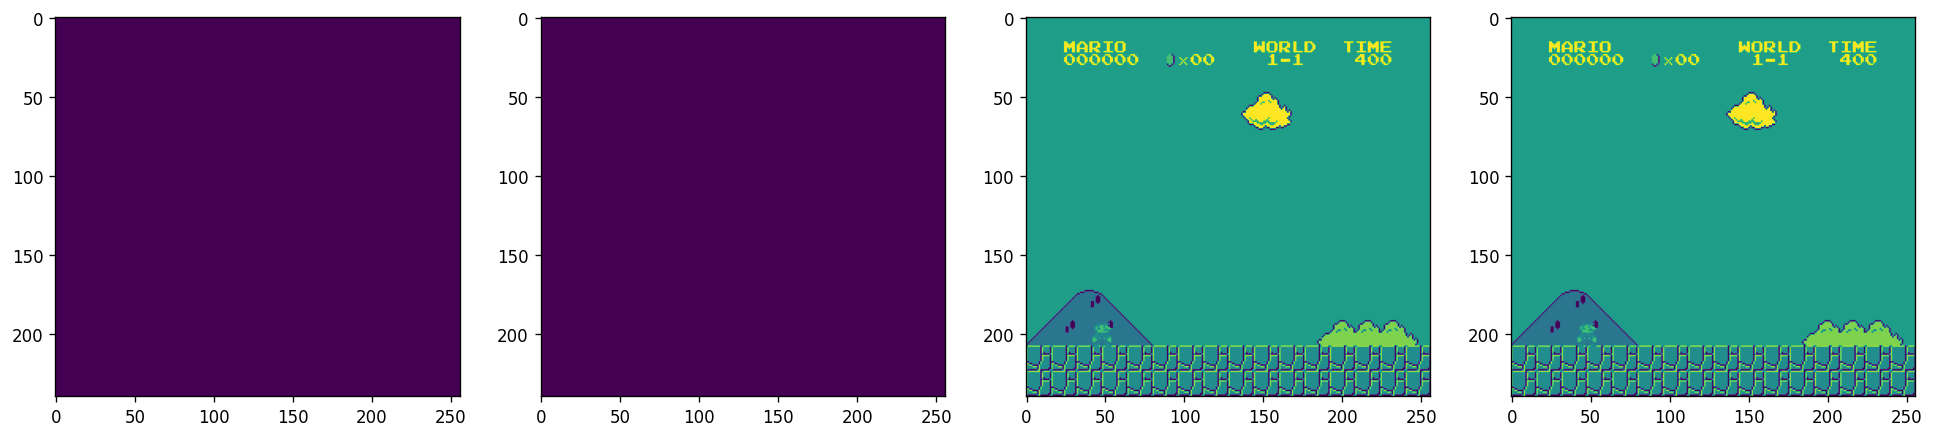

In [12]:
plt.figure(figsize=(20, 16))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx+1)
    plt.imshow(state[0][:, :, idx])
plt.show();

# Step 3 - Implementing Reinforcement Learning Model

In [13]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [14]:
CHECKPOINT_DIR = './train'
LOG_DIR = './logs'

In [15]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq: int, save_path: str, verbose: int = 1):
      super().__init__(verbose)
      self.check_freq = check_freq
      self.save_path = save_path
    
    def _init_callback(self) -> None:
      if self.save_path is not None:
        os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self) -> bool:
      if self.n_calls % self.check_freq == 0:
       model_path = os.path.join(self.save_path, f"best_model_{self.n_calls}")
       self.model.save(model_path)

      return True

In [16]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [17]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [20]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs\PPO_3
----------------------------
| time/              |     |
|    fps             | 98  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 17            |
|    iterations           | 2             |
|    time_elapsed         | 59            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00013847416 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.0125        |
|    learning_rate        | 1e-06         |
|    loss                 | 160           |
|    n_updates            | 70            |
|    policy_gradient_loss | 0.000599      |
|    value_loss           | 424           |
-------------------------

In [21]:
model.save(path="./models/mymodel")

c:\Users\MSI\AppData\Local\Programs\Python\Python38\lib\site-packages\stable_baselines3\common\save_util.py:278: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
